In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats.stats import pearsonr
from IPython.display import display, Markdown, Latex
plt.style.use('ggplot')

from datetime import timedelta
from dateutil.parser import parse
data_path = '/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/'

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_9227/460733291.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


# Load and forma mobility data for BC, Washington, Oregon, California 

In [2]:
mobility_data = pd.DataFrame()
for year in [2020, 2021, 2022]:
    df = pd.read_csv(data_path + f'google_mobility/clean/US_{year}.csv')
    mobility_data = mobility_data.append(df)
    
for year in [2020, 2021, 2022]:
    df = pd.read_csv(data_path + f'google_mobility/clean/CA_{year}.csv')
    mobility_data = mobility_data.append(df)

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_9227/343977191.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path + f'google_mobility/clean/US_{year}.csv')
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_9227/343977191.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mobility_data = mobility_data.append(df)
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_9227/343977191.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path + f'google_mobility/clean/US_{year}.csv')
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_9227/343977191.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mobility_data = mobility_da

In [3]:
nw_mobility = mobility_data[mobility_data['state'].isin(['Washington', 'California', 'Oregon', 'British Columbia'])]

In [4]:
nw_mobility = nw_mobility.dropna(subset='county')

In [5]:
nw_mobility['location'] = nw_mobility['county'] + ', ' + nw_mobility['state']

In [6]:
nw_mobility[nw_mobility['state'] == 'British Columbia']['county'].unique()

array(['Alberni-Clayoquot', 'Bulkley-Nechako', 'Capital', 'Cariboo',
       'Central Kootenay', 'Central Okanagan', 'Columbia-Shuswap',
       'Comox Valley', 'Cowichan Valley', 'East Kootenay',
       'Fraser Valley', 'Fraser-Fort George', 'Kitimat-Stikine',
       'Kootenay Boundary', 'Metro Vancouver', 'Mount Waddington',
       'Nanaimo', 'North Coast', 'North Okanagan', 'Okanagan-Similkameen',
       'Peace River', 'qathet Regional District', 'Squamish-Lillooet',
       'Strathcona', 'Sunshine Coast Regional District',
       'Thompson-Nicola'], dtype=object)

In [7]:
nw_mobility['date'] = pd.to_datetime(nw_mobility['date'])

In [8]:
nw_mobility['year'] = [x.year for x in nw_mobility['date']]

In [9]:
nw_mobility.groupby('year')['residential'].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2020,34246.0,8.391257,6.318755,-7.0,4.0,8.0,12.0,37.0
2021,43782.0,5.519666,4.721171,-10.0,2.0,5.0,8.0,34.0
2022,34591.0,3.433986,3.661568,-8.0,1.0,3.0,5.0,29.0


In [10]:
nw_mobility.replace('Sunshine Coast Regional District', "Sunshine Coast", inplace=True)
nw_mobility.replace('Metro Vancouver', "Greater Vancouver", inplace=True)
nw_mobility['location'] = nw_mobility['county'] + ', ' + nw_mobility['state']



In [11]:
len(nw_mobility['location'].unique())

152

In [12]:
nw_mobility.replace('Sunshine Coast Regional District', "Sunshine Coast", inplace=True)
nw_mobility.replace('Metro Vancouver', "Greater Vancouver", inplace=True)
nw_mobility['location'] = nw_mobility['county'] + ', ' + nw_mobility['state']


### Load/Clean/Format Heatwave - Control Data

In [13]:
heatwave_control = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave_control/heatwave_control_clean_90_v1.csv')

In [14]:
heatwave_control.rename(columns={'datetime': 'date'}, inplace=True)

In [15]:
heatwave_control['control_day'] = [parse(x) for x in heatwave_control['control_day']]
heatwave_control['date'] = [parse(x) for x in heatwave_control['date']]

In [16]:
heatwave_control['diff'] = (heatwave_control['date'] - heatwave_control['control_day'])

In [20]:
heatwave_control['diff'].describe()

count                         7500
mean        9 days 13:22:33.600000
std      6 days 18:01:26.327610808
min             -14 days +00:00:00
25%                7 days 00:00:00
50%                7 days 00:00:00
75%               14 days 00:00:00
max               49 days 00:00:00
Name: diff, dtype: object

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_9227/2860178666.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(heatwave_control['diff'].dt.days)


Text(0, 0.5, 'Heat and Control Difference')

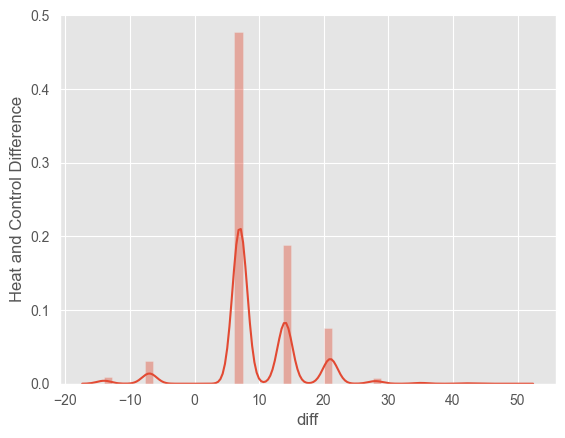

In [24]:
sns.distplot(heatwave_control['diff'].dt.days)
plt.ylabel("Heat and Control Difference")

In [25]:
us_heatwave_control = heatwave_control[heatwave_control['state'].isin(['California', 'Oregon', 'Washington'])]
us_heatwave_control['county'] = us_heatwave_control['county'] + ' County'
us_heatwave_control['location'] = us_heatwave_control['county'] + ', ' + us_heatwave_control['state']

ca_heatwave_control = heatwave_control[heatwave_control['state'] == 'British Columbia']
ca_heatwave_control['location'] = ca_heatwave_control['county'] + ', ' + ca_heatwave_control['state']

nw_heatwave_control = us_heatwave_control.append(ca_heatwave_control)

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_9227/4142719573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_heatwave_control['county'] = us_heatwave_control['county'] + ' County'
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_9227/4142719573.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_heatwave_control['location'] = us_heatwave_control['county'] + ', ' + us_heatwave_control['state']
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_9227/4142719573.py:6: S

In [318]:
#nw_heatwave_control.to_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave_control/simple_format_heatwave_control_v6_95.csv')

### Merge Mobility with Heat Data

In [26]:
nw_mobility.drop_duplicates(['location', 'date'], inplace=True)

In [27]:
mobility_heat = nw_mobility.merge(nw_heatwave_control[['control_day', 'temperature_2m', 'location', 'date', 'heat_ID']], on=['location', 'date'])

In [28]:
#merge mobility data associated with control dates
mobility_heat = mobility_heat.merge(nw_mobility[['location', 'date', 'retail', 'grocery_pharmacy', 'parks', 'transit', 'workplaces', 'residential']], left_on=['location', 'control_day'], right_on=['location', 'date'], suffixes=['_heat', '_control'])

In [29]:
#calculate differences between heat and control 
mobility_heat['retail_difference'] = mobility_heat['retail_heat'] - mobility_heat['retail_control']
mobility_heat['grocery_pharmacy_difference'] = mobility_heat['grocery_pharmacy_heat'] - mobility_heat['grocery_pharmacy_control']
mobility_heat['parks_difference'] = mobility_heat['parks_heat'] - mobility_heat['parks_control']
mobility_heat['transit_difference'] = mobility_heat['transit_heat'] - mobility_heat['transit_control']
mobility_heat['workplaces_difference'] = mobility_heat['workplaces_heat'] - mobility_heat['workplaces_control']
mobility_heat['residential_difference'] = mobility_heat['residential_heat'] - mobility_heat['residential_control']

In [30]:
mobility_heat['day_of_week'] = [x.day_of_week for x in mobility_heat['date_heat']]
mobility_heat['weekend'] = [1 if x in [5,6] else 0 for x in mobility_heat['day_of_week']]

In [31]:
mobility_heat.reset_index(drop=True,inplace=True)

In [32]:
mobility_heat.to_csv(data_path + 'mobility_heat/mobility_heat_clean_90_v1.csv')